# Cluster Distance Transformer

In [1]:
import csv
from datetime import datetime
import json
import math
import os
import sys
import time

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch import Tensor
from torch.nn import (TransformerDecoder, TransformerDecoderLayer,
                      TransformerEncoder, TransformerEncoderLayer)
from torch.utils.data import DataLoader
from tqdm import tqdm

f:\d_drive\workspace\stocknet_study\venv_38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
try:
  from google.colab import drive
  IS_GOOGLE_COLAB = True
except ImportError:
  IS_GOOGLE_COLAB = False

if IS_GOOGLE_COLAB:
  mount_path = '/content/drive'
  base_folder = os.path.join(mount_path, "My Drive", "Data")
  data_folder = os.path.join(base_folder, "FX")
else:
  base_folder = '../../../Data'
  data_folder = os.path.join(base_folder, "FX", "OANDA-Japan MT5 Live")

In [3]:
import os
import shutil
import sys
import zipfile
import requests

def download_modlue_from_gh(repository, github_account='Naradice', branch='master', folder=None, module_path='/gdrive/My Drive/modules', **kwargs):
  if folder is None:
    folder = repository

  zip_url = f"https://github.com/{github_account}/{repository}/archive/refs/heads/{branch}.zip"
  response = requests.get(zip_url)
  if response.status_code == 200:
    with open("temp.zip", "wb") as f:
      f.write(response.content)
    with zipfile.ZipFile("temp.zip", "r") as zip_ref:
      zip_ref.extractall("temp_dir")

    source_folder = f"temp_dir/{repository}-{branch}/{folder}"
    destination_folder = os.path.join(module_path, folder)
    shutil.copytree(source_folder, destination_folder, dirs_exist_ok=True)
    os.remove("temp.zip")
    shutil.rmtree("temp_dir")
  else:
    print(f"filed to download {zip_url}: {response.status_code}, {response.text}")

In [4]:
if IS_GOOGLE_COLAB:
  drive.mount(mount_path)
  module_path = f"{mount_path}/My Drive/modules"
else:
  module_path = '../../modules'

if os.path.exists(module_path) is False:
  os.makedirs(module_path)

repositories = [
    {'repository': 'stocknet_study', 'branch': 'master', 'folder': 'Dataset', 'refresh': False},
    {'repository': 'finance_process', 'branch': 'master', 'folder': 'fprocess', 'refresh': False},
    {'repository': 'cloud_storage_handler', 'branch': 'main', 'folder': 'cloud_storage_handler', 'refresh': False},
]

destination = os.path.join(module_path, '__init__.py')
if os.path.exists(destination) is False:
  with open(destination, mode='w') as fp:
    fp.close()

for repo_kwargs in repositories:
  destination = os.path.join(module_path, repo_kwargs['folder'])
  if repo_kwargs['refresh'] or os.path.exists(destination) is False:
    download_modlue_from_gh(**repo_kwargs, module_path=module_path)

In [5]:
sys.path.append(module_path)

import fprocess
import Dataset
import cloud_storage_handler

In [6]:
class Logger:

  @classmethod
  def connect_drive(cls, mount_path='/content/drive'):
    from google.colab import drive
    drive.mount(mount_path)

  def __init__(self, model_name, version, base_path=None, storage_handler='colab', max_retry=3, local_cache_period=10, client_id=None):
    """ Logging class to store training logs

    Args:
        model_name (str): It create a folder {base_path}/{model_name}/.
        verison (str): It create a file {base_path}/{model_name}/{model_name}_v{version}.csv.
        base_path (str, optional): Base path to store logs. If you use cloud storage, this is used as temporal folder. Defaults to None.
        storage_handler (str|BaseHandler, optional): It change storage service. 'colab' can be selected. Defaults to 'colab'.
        max_retry (int, optional): max count of retry when store logs via network. Defaults to 3.
        local_cache_period(int, optional): Valid for cloud storage only. period to chache logs until send it to the storage. Defaults to 10.
        client_id(str, optional): client_id to authenticate cloud service with OAuth2.0/OIDC. Defaults to None.
    """
    # define common veriables
    MOUNT_PATH = '/content/drive'
    self.__use_cloud_storage = False
    self.__init_storage = lambda : None
    self.__local_cache_period = local_cache_period
    self.model_name = model_name
    self.version = version
    self.max_retry = max_retry

    # define variables depends on env
    if storage_handler == 'colab':
      # this case we store logs on mounted path
      self.__init_colab()
      self.__init_storage = self.__init_colab
      if base_path is None:
        self.base_path = MOUNT_PATH
      else:
        base_pathes = [p for p in base_path.split('/') if len(p) > 0]
        self.base_path = os.path.join(MOUNT_PATH, 'My Drive', *base_pathes)
    elif type(storage_handler) is str:
      raise ValueError(f"{storage_handler} is not supported. Please create StorageHandler for the service.")
    elif storage_handler is not None:
      # this case we store logs on app folder of dropbox, using cloud_storage_handlder
      self.__cloud_handler = storage_handler
      if self.__cloud_handler.refresh_token is None:
        self.__cloud_handler.authenticate()
      self.__use_cloud_storage = True
      if base_path is None:
        self.base_path = './'
      else:
        self.base_path = base_path
    else:
      self.__cloud_handler = None
      if base_path is None:
        self.base_path = './'
      else:
        self.base_path = base_path
    model_log_folder = os.path.join(self.base_path, model_name)
    if not os.path.exists(model_log_folder):
        os.makedirs(model_log_folder)
    file_name = f"{model_name}_v{version}.csv"
    self.log_file_path = os.path.join(model_log_folder, file_name)
    self.__cache = []

  def __init_colab(self):
    from google.colab import drive
    drive.mount(MOUNT_PATH)

  def __store_files_to_cloud_storage(self, file_path):
    try:
      self.__cloud_handler.upload_training_results(self.model_name, [file_path])
    except Exception as e:
      print(f"failed to save logs to dropbox: {e}")

  def reset(self, model_name=None, file_name=None):
    if file_name is None:
      file_name = datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
    if model_name is None:
      if file_name is None:
        raise ValueError("Either model_name or file_name should be specified")
      self.log_file_path = os.path.join(self.base_path, file_name)
    else:
      model_log_folder = os.path.join(self.base_path, model_name)
      if not os.path.exists(model_log_folder):
        os.makedirs(model_log_folder)
      self.log_file_path = os.path.join(model_log_folder, file_name)
    self.__cache = []

  def __cache_log(self, log_entry: list):
    self.__cache.append(log_entry)

  def __append_log(self, log_entry:list, retry_count=0):
      try:
          with open(self.log_file_path, 'a') as log_file:
            writer = csv.writer(log_file)
            if len(self.__cache) > 0:
              writer.writerows(self.__cache)
              self.__cache = []
            writer.writerow(log_entry)
      except Exception as e:
        if retry_count < self.max_retry:
          if retry_count == 0:
            print(e)
          self.__init_storage()
          self.__append_log(log_entry, retry_count+1)
        else:
          self.__cache.append(log_entry)

  def save_params(self, params:dict, model_name=None, model_version=None):
    data_folder = os.path.dirname(self.log_file_path)
    param_file_path = os.path.join(data_folder, f'{model_name}_v{model_version}_params.json')
    if "device" in params:
      device = params["device"]
      if not isinstance(device, str):
        params["device"] = str(device)
    with open(param_file_path, mode="w") as fp:
      json.dump(params, fp)
    if self.__use_cloud_storage:
      self.__store_files_to_cloud_storage(param_file_path)

  def save_model(self, model, model_name=None, model_version=None):
    if model is not None:
      data_folder = os.path.dirname(self.log_file_path)
      param_file_path = os.path.join(data_folder, f'{model_name}_v{model_version}.torch')
      torch.save(model.state_dict(), param_file_path)
      if self.__use_cloud_storage:
        self.__store_files_to_cloud_storage(param_file_path)

  def save_checkpoint(self, model, optimizer, scheduler, model_name, model_version, **kwargs):
    if model is not None:
      data_folder = os.path.dirname(self.log_file_path)
      model_path = os.path.join(data_folder, f'{model_name}_v{model_version}.torch')
      torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        **kwargs
      }, model_path)
      if self.__use_cloud_storage:
        self.__store_files_to_cloud_storage(model_path)

  def save_logs(self):
    if len(self.__cache) > 0:
      with open(self.log_file_path, 'a') as log_file:
        if len(self.__cache) > 0:
          writer = csv.writer(log_file)
          writer.writerows(self.__cache)
    if self.__use_cloud_storage:
        self.__store_files_to_cloud_storage(self.log_file_path)

  def add_training_log(self, training_loss, validation_loss, log_entry:list=None):
    timestamp = datetime.now().isoformat()
    basic_entry = [timestamp, training_loss, validation_loss]
    if log_entry is not None:
      if type(log_entry) is list and len(log_entry) > 0:
        basic_entry.extend(log_entry)
    if len(self.__cache) < self.__local_cache_period:
      self.__cache_log(basic_entry)
    else:
      self.__append_log(basic_entry)
      if self.__use_cloud_storage:
        self.__store_files_to_cloud_storage(self.log_file_path)

  def get_min_losses(self, train_loss_column=1, val_loss_column=2):
    logs = None
    if os.path.exists(self.log_file_path) is False:
      if self.__cloud_handler is not None:
        file_name = os.path.dirname(self.log_file_path)
        destination_path = f'/{self.model_name}/{file_name}'
        response = self.__cloud_handler.download_file(destination_path, self.log_file_path)
        if response is not None:
          logs = pd.read_csv(self.log_file_path)
    else:
      try:
        logs = pd.read_csv(self.log_file_path)
      except pd.errors.EmptyDataError:
        logs = None

    if logs is None:
      print("no log available")
      return np.inf, np.inf
    else:
      if type(train_loss_column) is int:
        train_loss = logs.iloc[:, train_loss_column]
      elif type(train_loss_column) is str:
        train_loss = logs[train_loss_column]
      min_train_loss = train_loss.min()

      if type(val_loss_column) is int:
        val_loss = logs.iloc[:, val_loss_column]
      elif type(val_loss_column) is str:
        val_loss = logs[val_loss_column]
      min_val_loss = val_loss.min()

      return min_train_loss, min_val_loss

In [7]:
# Initialize cloud storage handler if needed
from cloud_storage_handler import DropboxHandler


# storage_handler = DropboxHandler("nhjrq1cjpugk5hc", "http://localhost")
# storage_handler.authenticate()
# Otherwise, specify None
storage_handler = None

In [8]:
def load_model(model_name, model_version, device, train=True, storage_handler=None, model_folder=None, optimizer_class=None, scheduler_class=None):
  if model_folder is None:
    model_folder = base_folder
  model_folder = os.path.join(model_folder, model_name)

  params_file_name = f'{model_folder}/{model_name}_v{model_version}_params.json'
  if os.path.exists(params_file_name) is False:
    if storage_handler is None:
      print(f"exsisting model params not found on {params_file_name}.")
      return None, None, None, None
    else:
      response = storage_handler.download_file(f"/{model_name}/{model_name}_v{model_version}_params.json", params_file_name)
      if response is None:
        print("exsisting model params not found.")
        return None, None, None, None
  with open(params_file_name) as fp:
      params = json.load(fp)
  # need to create create_model function for respective model
  if "device" not in params:
    params["device"] = device
  model = create_model(**params, feature_size=len(params["features"])).to(device)
  optimizer = optimizer_class(model.parameters(), lr=lr)
  scheduler = scheduler_class(optimizer, 1.0)
  if train:
    model_path = f'{model_folder}/{model_name}_train_v{model_version}.torch'
  else:
    model_path = f'{model_folder}/{model_name}_v{model_version}.torch'
  if os.path.exists(model_path) is False:
    if storage_handler is None:
      print("exsisting model not found.")
      return None, None, None, None
    file_name = os.path.basename(model_path)
    response = storage_handler.download_file(f"/{model_name}/{file_name}", model_path)
    if response is None:
      print("exsisting model not found.")
      return None, None, None, None

  if torch.cuda.is_available():
    check_point = torch.load(model_path)
  else:
    check_point = torch.load(model_path, map_location=torch.device('cpu'))
  if "model_state_dict" in check_point:
    model.load_state_dict(check_point['model_state_dict'])
    optimizer.load_state_dict(check_point['optimizer_state_dict'])
    scheduler.load_state_dict(check_point['scheduler_state_dict'])
    return params, model, optimizer, scheduler
  else:
    if optimizer_class is not None:
      print("checkpoint is not available.")
    model.load_state_dict(check_point)
    return params, model, None, None

# Cluster Distance Dataset

In [9]:
import random

def k_means(src_df, label_num_k, initial_centers = None, max_iter = 10000):
  np.random.seed(100)
  random.seed(100)
  
  count = 0

  labels = np.fromiter(random.choices(range(label_num_k), k=src_df.shape[0]), dtype = int)
  labels_prev = np.zeros(src_df.shape[0])
  if initial_centers is None:
    cluster_centers = np.eye(label_num_k, src_df.shape[1])
  else:
    initial_centers = np.array(initial_centers)
    if initial_centers.shape == (label_num_k, src_df.shape[1]):
      cluster_centers = initial_centers
    else:
      raise ValueError("invalid initial centeers")

  while (not (labels == labels_prev).all()):
      for i in range(label_num_k):
          clusters = src_df.iloc[labels == i]
          if len(clusters) > 0:
            cluster_centers[i, :] = clusters.mean(axis = 0)
          else:
            cluster_centers[i, :] = np.ones(src_df.shape[1])
      dist = ((src_df.values[:, :, np.newaxis] - cluster_centers.T[np.newaxis, :, :]) ** 2).sum(axis = 1)
      # dist = np.sqrt(dist)
      labels_prev = labels
      labels = dist.argmin(axis = 1)
      count += 1
      if count > max_iter:
        break
  return labels, cluster_centers

In [10]:
# Freedman–Diaconis rule. Sometimes 0 count appeare due to outfliers.
def freedamn_diaconis_bins(data):
    q75, q25 = np.percentile(data, [75 ,25])

    iqr = q75 - q25
    n = len(data)
    bin_width = (2.0 * iqr / (n**(1/3)))
    return bin_width

def prob_mass(data, bin_width=None):
    if bin_width is None:
        counts, bin_edges = np.histogram(data)
    else:
        try:
            bins=np.arange(min(data), max(data) + bin_width, bin_width)
            counts, bin_edges = np.histogram(data, bins=bins)
        except ValueError:
            counts, bin_edges = np.histogram(data)
    mass = counts / counts.sum()
    return mass, bin_edges

In [11]:
from Dataset.base import TimeDataset

class ClusterDistDataset(TimeDataset):
    
    def __init__(
        self,
        df,
        columns: list,
        label_num_k:int = 30,
        freq=30,
        observation_length: int = 60,
        device="cuda",
        prediction_length=10,
        seed=1017,
        is_training=True,
        randomize=True,
        index_sampler=None,
        split_ratio=0.8,
        indices=None,
    ):
        diff_p = fprocess.DiffPreProcess(columns=columns)
        src_df = df[columns].dropna()
        src_df = diff_p(src_df).dropna()
        processes = [fprocess.WeeklyIDProcess(freq=freq, time_column= "index")]
        
        divisions = [i / (label_num_k-1) for i in range(label_num_k)]
        ini_centers = [
            np.quantile(src_df, p, axis=0) for p in divisions
        ]
        labels, centers = k_means(src_df, label_num_k=label_num_k, initial_centers=ini_centers)
        self.centers = centers
        dist = ((src_df.values[:, :, np.newaxis] - centers.T[np.newaxis, :, :]) ** 2).sum(axis = 1)
        token_df = pd.DataFrame(dist, index=src_df.index)
        super().__init__(token_df, columns=token_df.columns, observation_length=observation_length, processes=processes,
                         device=device, prediction_length=prediction_length, seed=seed, is_training=is_training, randomize=randomize,
                         index_sampler=index_sampler, split_ratio=split_ratio, indices=indices, dtype=torch.float)
        
    
    def to_labels(self, observations):
        if isinstance(observations, pd.DataFrame):
            observations = observations.values
        dist = ((observations[:, :, np.newaxis] - self.centers.T[np.newaxis, :, :]) ** 2).sum(axis = 1)
        labels = dist.argmin(axis = 1)
        return labels
    
    def output_indices(self, index):
        # output overrap with last input
        return slice(index + self.observation_length - 1, index + self.observation_length + self._prediction_length)

    def __getitem__(self, ndx):
        src, src_time = self._input_func(ndx)
        ans, ans_time = self._output_func(ndx)
        src = src.squeeze()
        ans = ans.squeeze()
        return (src, src_time), (ans, ans_time)

# Simple Transformer

In [12]:
class PositionalEncoding(nn.Module):
    def __init__(self, time_size, d_model, dropout=0.1, device=None):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.pe = nn.Embedding(time_size, d_model, device=device)

    def forward(self,time_ids):
        position = self.pe(time_ids)
        return self.dropout(position)

In [13]:
class Seq2SeqTransformer(nn.Module):
    
    def __init__(
        self, num_encoder_layers: int, num_decoder_layers: int,
        cluster_size: int, time_size: int, d_model: int,
        dim_feedforward:int = 512, dropout:float = 0.1, nhead:int = 8, device=None
    ):
        
        super(Seq2SeqTransformer, self).__init__()

        self.dropout_layer = nn.Dropout(dropout)
        self.tgt_dropout_layer = nn.Dropout(dropout)
        self.positional_encoding = PositionalEncoding(time_size, cluster_size, dropout, device=device)
                
        encoder_layer = TransformerEncoderLayer(
            d_model=cluster_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, device=device
        )
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        
        decoder_layer = TransformerDecoderLayer(
            d_model=cluster_size, nhead=nhead, dim_feedforward=dim_feedforward,dropout=dropout, device=device
        )
        self.transformer_decoder = TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)
        # self.output_layer = nn.Linear(d_model, cluster_size, device=device)
        

    def forward(
        self, src: Tensor, src_time: Tensor,
        tgt: Tensor, tgt_time: Tensor,
        mask_tgt: Tensor, mask_src: Tensor=None, padding_mask_src: Tensor=None, padding_mask_tgt: Tensor=None,
        memory_key_padding_mask: Tensor=None
    ):
        src_pos = self.positional_encoding(src_time)
        src_emb = torch.add(src, src_pos)
        src_emb = self.dropout_layer(src_emb)
                
        tgt_pos = self.positional_encoding(tgt_time)
        tgt_emb = torch.add(tgt, tgt_pos)
        tgt_emb = self.tgt_dropout_layer(tgt_emb)
                
        memory = self.transformer_encoder(src_emb, mask_src, padding_mask_src)
        output = self.transformer_decoder(
            tgt_emb, memory, mask_tgt, None,
            padding_mask_tgt, memory_key_padding_mask
        )
        # output = self.output_layer(output)
        
        return output

In [14]:
def train(model, ds, optimizer, criterion, batch_size, cluster_size, device):
    
    model.train()
    ds.train()
    losses = 0
    
    length = 0.0
    end_index = len(ds)
    for index in tqdm(range(0, end_index - batch_size, batch_size)):
        length+=1.0
        src, tgt = ds[index:index+batch_size]
        src, src_time = src
        tgt, tgt_time = tgt
        
        in_tgt = tgt[:-1]
        in_tgt_time = tgt_time[:-1]

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(in_tgt.size(0)).to(device)
        out = model(
            src=src, src_time=src_time, tgt=in_tgt, tgt_time=in_tgt_time,
            mask_tgt=mask_tgt, padding_mask_src=None, padding_mask_tgt=None,
            memory_key_padding_mask=None
        )
        
        ans = tgt[1:]
        
        loss = criterion(out, ans)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses += loss.item()
        
    return losses / length

In [15]:
def evaluate(model, ds, criterion, batch_size, cluster_size, device):
    
    model.eval()
    ds.eval()
    losses = 0
    length = 0.0
    for index in range(0, len(ds) - batch_size, batch_size):
        length+=1.0
        src, tgt = ds[index:index+batch_size]
        src, src_time = src
        tgt, tgt_time = tgt
        
        in_tgt = tgt[:-1]
        in_tgt_time = tgt_time[:-1]

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(in_tgt.size(0)).to(device)
        out = model(
            src=src, src_time=src_time, tgt=in_tgt, tgt_time=in_tgt_time,
            mask_tgt=mask_tgt, padding_mask_src=None, padding_mask_tgt=None,
            memory_key_padding_mask=None
        )

        ans = tgt[1:]

        loss = criterion(out, ans)
        losses += loss.item()
        
    return losses / length

In [16]:
def create_model(num_encoder_layers: int, num_decoder_layers: int,
        cluster_size: int, time_size: int, d_model: int,
        dim_feedforward:int = 512, dropout:float = 0.1, nhead:int = 8, **kwargs):
    model = Seq2SeqTransformer(
        num_encoder_layers=int(num_encoder_layers),
        num_decoder_layers=int(num_decoder_layers),
        cluster_size=int(cluster_size),
        time_size=int(time_size),
        d_model=int(d_model),
        dim_feedforward=dim_feedforward,
        dropout=dropout, nhead=nhead
    )
    return model

## Training with Row Data 

In [17]:
import os
import pandas as pd

ohlc_column = ['open','high','low','close']
file_name = "mt5_USDJPY_min30.csv"

file_path = os.path.join(data_folder, file_name)
file_path = os.path.abspath(file_path)
df = pd.read_csv(file_path, parse_dates=True, index_col=0)
df

,open,high,low,close,tick_volume,spread,real_volume
time,,,,,,,
2014-07-07 08:30:00,102.086,102.122,102.081,102.102,738,3,0
2014-07-07 09:00:00,102.102,102.146,102.098,102.113,1036,3,0
2014-07-07 09:30:00,102.113,102.115,102.042,102.044,865,3,0
2014-07-07 10:00:00,102.047,102.052,102.005,102.019,983,3,0
2014-07-07 10:30:00,102.017,102.025,101.918,101.941,1328,3,0
...,...,...,...,...,...,...,...
2022-08-12 21:30:00,133.461,133.506,133.439,133.484,1125,3,0
2022-08-12 22:00:00,133.484,133.530,133.437,133.475,1277,3,0
2022-08-12 22:30:00,133.475,133.486,133.433,133.483,1506,3,0


In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_name = "finance_cluster_dist_transformer"

#Dataset parameters
columns = ["open", "close"]
batch_size = 64
observation_length = 60
prediction_length = 10
feature_size = 4
cluster_size = 30
lr=0.005


ds = ClusterDistDataset(df, columns, label_num_k=cluster_size, freq=30,
                    observation_length=observation_length, prediction_length=prediction_length, device=device)

In [19]:
# num of encoder version, cluss size version, d_model version
model_version = "1.1.1"
model_params, model, optimizer, scheduler = load_model(model_name, model_version, device, True, storage_handler=storage_handler,
                                 optimizer_class=torch.optim.Adam,
                                 scheduler_class=torch.optim.lr_scheduler.StepLR)

if model is None:
    print("Initialize a new model.")

    # Hyper parameters
    model_params = {
        "num_encoder_layers":2,
        "num_decoder_layers":2,
        "cluster_size":cluster_size,
        "time_size":int(7*24*(60/30)), 
        "d_model":12,
        "dim_feedforward":10,
        "dropout":0.1, "nhead":2
    }

    model = create_model(
        **model_params
    ).to(device)

params_num = 0
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)
    if p.requires_grad:
        params_num += p.numel()
print(f"params: {params_num}")

params: 35560


In [20]:
criterion = nn.MSELoss()
if optimizer is None:
    print("initialize optimizer")
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma = 0.9)

In [21]:
logger = Logger(model_name, model_version, base_folder, storage_handler=storage_handler, local_cache_period=1)

start_index, end_index = ds.get_date_range()
params = {"processes": [],
          "source": {
              "path": file_path,
              "start": start_index.isoformat(),
              "end": end_index.isoformat(),
              "length": len(ds)
          },
          "features": columns,
          "batch_size": batch_size,
          "observation_length": observation_length,
          "prediction_length": prediction_length,
          **model_params,
          "params_num": params_num,
          "version": 2
}

logger.save_params(params, model_name, model_version)
pd.DataFrame(ds.centers, columns=columns).to_csv(f"{base_folder}/{model_name}/{model_name}_label_centers_{model_version}.csv")

print("training log will be saved on ", logger.log_file_path)

training log will be saved on  ../../../Data\finance_cluster_dist_transformer\finance_cluster_dist_transformer_v1.1.1.csv


In [67]:
epoch = 500
best_train_loss, best_valid_loss = logger.get_min_losses()
best_model = None
best_train_model = None
patience = 3
counter = 0

for loop in range(1, epoch + 1):    
    start_time = time.time()
    
    loss_train = train(
        model=model, ds=ds, optimizer=optimizer,
        criterion=criterion, batch_size=batch_size, cluster_size=cluster_size, device=device
    )
    
    elapsed_time = time.time() - start_time
    
    loss_valid = evaluate(
        model=model, ds=ds, criterion=criterion,batch_size=batch_size, cluster_size=cluster_size, device=device
    )
       
    logger.add_training_log(loss_train, loss_valid, elapsed_time)
    
    if best_train_loss > loss_train:
        best_train_loss = loss_train
        best_train_model = model
        counter = 0
    else:
        counter += 1
        if counter == 1:
          logger.save_checkpoint(best_train_model, optimizer, scheduler, f'{model_name}_train', model_version)
        scheduler.step()
        
    print('[{}/{}] train loss: {:.10f}, valid loss: {:.10f}  [{}{:.0f}s] count: {}, {}'.format(
        loop, epoch,
        loss_train, loss_valid,
        str(int(math.floor(elapsed_time / 60))) + 'm' if math.floor(elapsed_time / 60) > 0 else '',
        elapsed_time % 60,
        counter,
        '**' if best_valid_loss > loss_valid else ''
    ))
    
    if best_valid_loss > loss_valid:
        best_valid_loss = loss_valid
        best_model = model
        logger.save_checkpoint(best_model, optimizer, scheduler, model_name, model_version)

    if counter > patience:
        break
    
logger.save_checkpoint(best_train_model, optimizer, scheduler, f'{model_name}_train', model_version)
logger.save_checkpoint(best_model, optimizer, scheduler, model_name, model_version)

no log available


100%|██████████| 1258/1258 [38:05<00:00,  1.82s/it]


[1/500] train loss: 0.0209095820, valid loss: 0.0078818435  6s] count: 0, **


100%|██████████| 1258/1258 [37:55<00:00,  1.81s/it]


[2/500] train loss: 0.0110969899, valid loss: 0.0073487212  56s] count: 0, **


100%|██████████| 1258/1258 [38:26<00:00,  1.83s/it]


[3/500] train loss: 0.0105289871, valid loss: 0.0067541248  27s] count: 0, **


100%|██████████| 1258/1258 [37:24<00:00,  1.78s/it]


[4/500] train loss: 0.0102513555, valid loss: 0.0064252684  25s] count: 0, **


100%|██████████| 1258/1258 [36:58<00:00,  1.76s/it]


[5/500] train loss: 0.0097769011, valid loss: 0.0064625266  59s] count: 0, 


100%|██████████| 1258/1258 [38:34<00:00,  1.84s/it]


[6/500] train loss: 0.0095889182, valid loss: 0.0068076276  35s] count: 0, 


100%|██████████| 1258/1258 [37:25<00:00,  1.79s/it]


[7/500] train loss: 0.0095192827, valid loss: 0.0073298255  26s] count: 0, 


100%|██████████| 1258/1258 [37:02<00:00,  1.77s/it]


[8/500] train loss: 0.0091840069, valid loss: 0.0076568233  2s] count: 0, 


100%|██████████| 1258/1258 [37:17<00:00,  1.78s/it] 


[9/500] train loss: 0.0095476852, valid loss: 0.0141580993  18s] count: 1, 


100%|██████████| 1258/1258 [30:51<00:00,  1.47s/it]


[10/500] train loss: 0.0100529921, valid loss: 0.0070152812  51s] count: 2, 


100%|██████████| 1258/1258 [31:59<00:00,  1.53s/it]


[11/500] train loss: 0.0090542667, valid loss: 0.0066123816  59s] count: 0, 


100%|██████████| 1258/1258 [31:59<00:00,  1.53s/it]


[12/500] train loss: 0.0087787605, valid loss: 0.0065958616  59s] count: 0, 


100%|██████████| 1258/1258 [31:56<00:00,  1.52s/it]


[13/500] train loss: 0.0086607723, valid loss: 0.0062837245  56s] count: 0, **


100%|██████████| 1258/1258 [33:05<00:00,  1.58s/it] 


[14/500] train loss: 0.0089291125, valid loss: 0.0095715600  6s] count: 1, 


100%|██████████| 1258/1258 [30:42<00:00,  1.46s/it]


[15/500] train loss: 0.0093212454, valid loss: 0.0069125599  42s] count: 2, 


100%|██████████| 1258/1258 [30:36<00:00,  1.46s/it]


[16/500] train loss: 0.0086893416, valid loss: 0.0071078439  36s] count: 3, 


100%|██████████| 1258/1258 [30:42<00:00,  1.46s/it]


[17/500] train loss: 0.0083032605, valid loss: 0.0063327202  43s] count: 0, 


100%|██████████| 1258/1258 [30:32<00:00,  1.46s/it]


[18/500] train loss: 0.0083327625, valid loss: 0.0070812736  33s] count: 1, 


100%|██████████| 1258/1258 [30:33<00:00,  1.46s/it]


[19/500] train loss: 0.0081901367, valid loss: 0.0066982073  33s] count: 0, 


100%|██████████| 1258/1258 [30:27<00:00,  1.45s/it]


[20/500] train loss: 0.0081128947, valid loss: 0.0066051565  28s] count: 0, 


100%|██████████| 1258/1258 [30:27<00:00,  1.45s/it]


[21/500] train loss: 0.0080372805, valid loss: 0.0068228521  27s] count: 0, 


100%|██████████| 1258/1258 [31:26<00:00,  1.50s/it]


[22/500] train loss: 0.0080608111, valid loss: 0.0068061243  27s] count: 1, 


100%|██████████| 1258/1258 [37:09<00:00,  1.77s/it]


[23/500] train loss: 0.0080079511, valid loss: 0.0069677417  9s] count: 0, 


100%|██████████| 1258/1258 [36:15<00:00,  1.73s/it]


[24/500] train loss: 0.0079268448, valid loss: 0.0069017111  15s] count: 0, 


100%|██████████| 1258/1258 [35:38<00:00,  1.70s/it]


[25/500] train loss: 0.0077733546, valid loss: 0.0069168546  38s] count: 0, 


100%|██████████| 1258/1258 [33:33<00:00,  1.60s/it]


[26/500] train loss: 0.0079397706, valid loss: 0.0072856132  34s] count: 1, 


100%|██████████| 1258/1258 [33:42<00:00,  1.61s/it]


[27/500] train loss: 0.0077021915, valid loss: 0.0074805008  43s] count: 0, 


100%|██████████| 1258/1258 [33:36<00:00,  1.60s/it]


[28/500] train loss: 0.0076193540, valid loss: 0.0074568828  37s] count: 0, 


100%|██████████| 1258/1258 [36:29<00:00,  1.74s/it]


[29/500] train loss: 0.0076845216, valid loss: 0.0080217313  30s] count: 1, 


100%|██████████| 1258/1258 [35:50<00:00,  1.71s/it]


[30/500] train loss: 0.0077416889, valid loss: 0.0075790669  51s] count: 2, 


100%|██████████| 1258/1258 [37:54<00:00,  1.81s/it]


[31/500] train loss: 0.0075482275, valid loss: 0.0074256115  55s] count: 0, 


100%|██████████| 1258/1258 [34:09<00:00,  1.63s/it]


[32/500] train loss: 0.0075412484, valid loss: 0.0071007803  9s] count: 0, 


100%|██████████| 1258/1258 [34:13<00:00,  1.63s/it]


[33/500] train loss: 0.0074684939, valid loss: 0.0072992055  13s] count: 0, 


100%|██████████| 1258/1258 [34:15<00:00,  1.63s/it]


[34/500] train loss: 0.0075577447, valid loss: 0.0069933706  16s] count: 1, 


100%|██████████| 1258/1258 [34:00<00:00,  1.62s/it]


[35/500] train loss: 0.0074332902, valid loss: 0.0068288636  1s] count: 0, 


100%|██████████| 1258/1258 [37:58<00:00,  1.81s/it]


[36/500] train loss: 0.0073794530, valid loss: 0.0065400618  58s] count: 0, 


100%|██████████| 1258/1258 [37:54<00:00,  1.81s/it]


[37/500] train loss: 0.0073815143, valid loss: 0.0069045865  54s] count: 1, 


100%|██████████| 1258/1258 [37:40<00:00,  1.80s/it]


[38/500] train loss: 0.0074269957, valid loss: 0.0068390119  40s] count: 2, 


100%|██████████| 1258/1258 [37:34<00:00,  1.79s/it]


[39/500] train loss: 0.0073455752, valid loss: 0.0072502478  35s] count: 0, 


100%|██████████| 1258/1258 [36:43<00:00,  1.75s/it]


[40/500] train loss: 0.0073378481, valid loss: 0.0069060363  44s] count: 0, 


100%|██████████| 1258/1258 [32:58<00:00,  1.57s/it]


[41/500] train loss: 0.0072343511, valid loss: 0.0071718196  59s] count: 0, 


100%|██████████| 1258/1258 [33:24<00:00,  1.59s/it]


[42/500] train loss: 0.0072685389, valid loss: 0.0067401708  25s] count: 1, 


100%|██████████| 1258/1258 [33:16<00:00,  1.59s/it]


[43/500] train loss: 0.0072005219, valid loss: 0.0070143781  16s] count: 0, 


100%|██████████| 1258/1258 [34:26<00:00,  1.64s/it]


[44/500] train loss: 0.0073033300, valid loss: 0.0065852499  26s] count: 1, 


100%|██████████| 1258/1258 [32:36<00:00,  1.56s/it]


[45/500] train loss: 0.0072029485, valid loss: 0.0066970432  37s] count: 2, 


100%|██████████| 1258/1258 [32:59<00:00,  1.57s/it]


[46/500] train loss: 0.0072193286, valid loss: 0.0072849973  60s] count: 3, 


100%|██████████| 1258/1258 [34:43<00:00,  1.66s/it]


[47/500] train loss: 0.0071511275, valid loss: 0.0064859491  43s] count: 0, 


100%|██████████| 1258/1258 [34:37<00:00,  1.65s/it] 


[48/500] train loss: 0.0071632474, valid loss: 0.0067522845  37s] count: 1, 


100%|██████████| 1258/1258 [33:52<00:00,  1.62s/it]


[49/500] train loss: 0.0070977595, valid loss: 0.0070005898  52s] count: 0, 


100%|██████████| 1258/1258 [33:52<00:00,  1.62s/it]


[50/500] train loss: 0.0071238658, valid loss: 0.0071127373  53s] count: 1, 


100%|██████████| 1258/1258 [33:58<00:00,  1.62s/it]


[51/500] train loss: 0.0071068885, valid loss: 0.0069898499  58s] count: 2, 


100%|██████████| 1258/1258 [33:45<00:00,  1.61s/it]


[52/500] train loss: 0.0071479169, valid loss: 0.0067151624  46s] count: 3, 


100%|██████████| 1258/1258 [33:26<00:00,  1.60s/it] 


[53/500] train loss: 0.0070998066, valid loss: 0.0069336443  27s] count: 4, 


## Validation

In [22]:
model_name = "finance_cluster_dist_transformer"
model_version = "1.1.1"
_, model, _, _ = load_model(model_name, model_version, device, False, storage_handler=storage_handler,optimizer_class=torch.optim.Adam,
                                 scheduler_class=torch.optim.lr_scheduler.StepLR)
model = model.to(device)   

### Confirm how to revert values

In [23]:
centers = pd.read_csv(f"{base_folder}/{model_name}/{model_name}_label_centers_{model_version}.csv", index_col=0)

In [24]:
ds.eval()
initial_index = 0
src, tgt = ds[initial_index: initial_index + batch_size]

observation, obs_time = src
ans, ans_time = tgt

In [25]:
# prediction_length, chunk_size, cluster_size
distances = ans[0, 0, :].cpu().numpy()

In [127]:
def overlap_index(centers, distances, unit=0.001, rep_index=0):
    c_0 = centers.iloc[rep_index]
    d_0 = (distances[rep_index] // unit) * unit
    d_0 = math.sqrt(d_0)
    results = []
    
    for index in range(len(centers)):
        if index == rep_index:
            continue
        c_0i_dist = ((centers.iloc[index] - c_0) ** 2).sum()
        c_0i_dist = (math.sqrt(c_0i_dist) // unit) * unit
        d_i = (math.sqrt(distances[index]) // unit) * unit
        
        if (d_0 + d_i) - c_0i_dist > -unit:
            results.append(index)
        else:
            print(f"{index}: {(d_0 + d_i)} < {c_0i_dist}")
    return results

In [159]:
def is_same_point(point_a, point_b, unit=0.001):
    for index in range(len(point_a)):
        if abs(point_a[index] - point_b[index]) >= 0.001:
            return False
    return True

def have_same_point(point, candidates, unit=0.001, __return_index=False):
    for index, c in enumerate(candidates):
        if is_same_point(point, c, unit) is True:
            if __return_index is True:
                return True, index
            else:
                return True
    if __return_index is True:
        return False, -1
    else:
        return False

In [169]:
from sympy import symbols, Eq, solve, Add

def get_analytic_point(unit=0.001):
    x, y = symbols('x y')
    overlapped = overlap_index(centers, distances, unit)
    eq1 = Eq((x - centers["open"][0])**2 + (y - centers["close"][0])**2, distances[0])

    candidates = None
    answers = []
    answer_counts = []
    for index in overlapped:
        eq2 = Eq((x - centers["open"][index])**2 + (y - centers["close"][index])**2, distances[index])
        solution = solve((eq1, eq2), (x, y))
        for c in solution:
            if not isinstance(c, Add):
                if candidates is None:
                    candidates = (np.asarray([c]) // unit) * unit
                else:
                    is_same_p, ans_index = have_same_point(c, answers, unit, True)
                    if is_same_p is True:
                        answer_counts[ans_index] += 1
                    else:
                        c = (np.asarray(c) // unit) * unit
                        if have_same_point(c, candidates, unit):
                            answers.append(c)
                            answer_counts.append(1)
                        candidates = np.vstack([candidates, c])
                        
    if len(answers) > 0:
        return True, answers, answer_counts
    else:
        return False, candidates, None

In [170]:
# revert point
suc, point, counts = get_analytic_point()
point

[array([-0.0210000000000000, 0.0260000000000000], dtype=object),
 array([-0.0210000000000000, 0.0270000000000000], dtype=object),
 array([-0.0200000000000000, 0.0300000000000000], dtype=object),
 array([-0.0200000000000000, 0.0270000000000000], dtype=object)]

In [171]:
counts

[15, 8, 1, 4]

In [143]:
# confirm row data. we got chunk 0, so is data of initial_index
first_index = ds.get_actual_index(initial_index)
# check answers. analytic coord points almost the same the point (this is not a predicted value)
df[columns].diff().dropna().iloc[first_index + observation_length-1]

open    -0.020
close    0.027
Name: 2021-01-25 21:00:00, dtype: float64

In [256]:
# Even we use the answer value, we may not be able to completely revert the value from cluster distances.
# Here we try to caliculate possible areas and it possibilities
# First, we plot areas of predictions and the answer
preds_tgt = observation[-1:]
entire_tgt_time = (obs_time[-11:] + 10) % int(7 * 24 * (60//30))
preds_tgt_time = entire_tgt_time[:1]

for i in range(0, 10):
    mask_tgt = nn.Transformer.generate_square_subsequent_mask(preds_tgt.size(0)).to(device)

    out = model(
        src=observation, src_time=obs_time, tgt=preds_tgt, tgt_time=preds_tgt_time,
        mask_tgt=mask_tgt, padding_mask_src=None, padding_mask_tgt=None,
        memory_key_padding_mask=None
    )
    
    preds_tgt_time = entire_tgt_time[:i+2]
    preds_tgt = torch.concat([preds_tgt, out[-1:, :, :]])

In [224]:
preds_tgt[1:, 0, 0]

tensor([0.0052, 0.0108, 0.0115, 0.0106, 0.0065, 0.0161, 0.0118, 0.0251, 0.0120,
        0.0117], device='cuda:0', grad_fn=<SelectBackward0>)

In [265]:
# sample 1
batch_index = 0
# preds_tgt[0] is last value of observation. So we ignore it
pred_distances = preds_tgt[1:, batch_index, :]
pred_distances = pred_distances.cpu().detach().numpy()
pred_distances = np.abs(pred_distances)

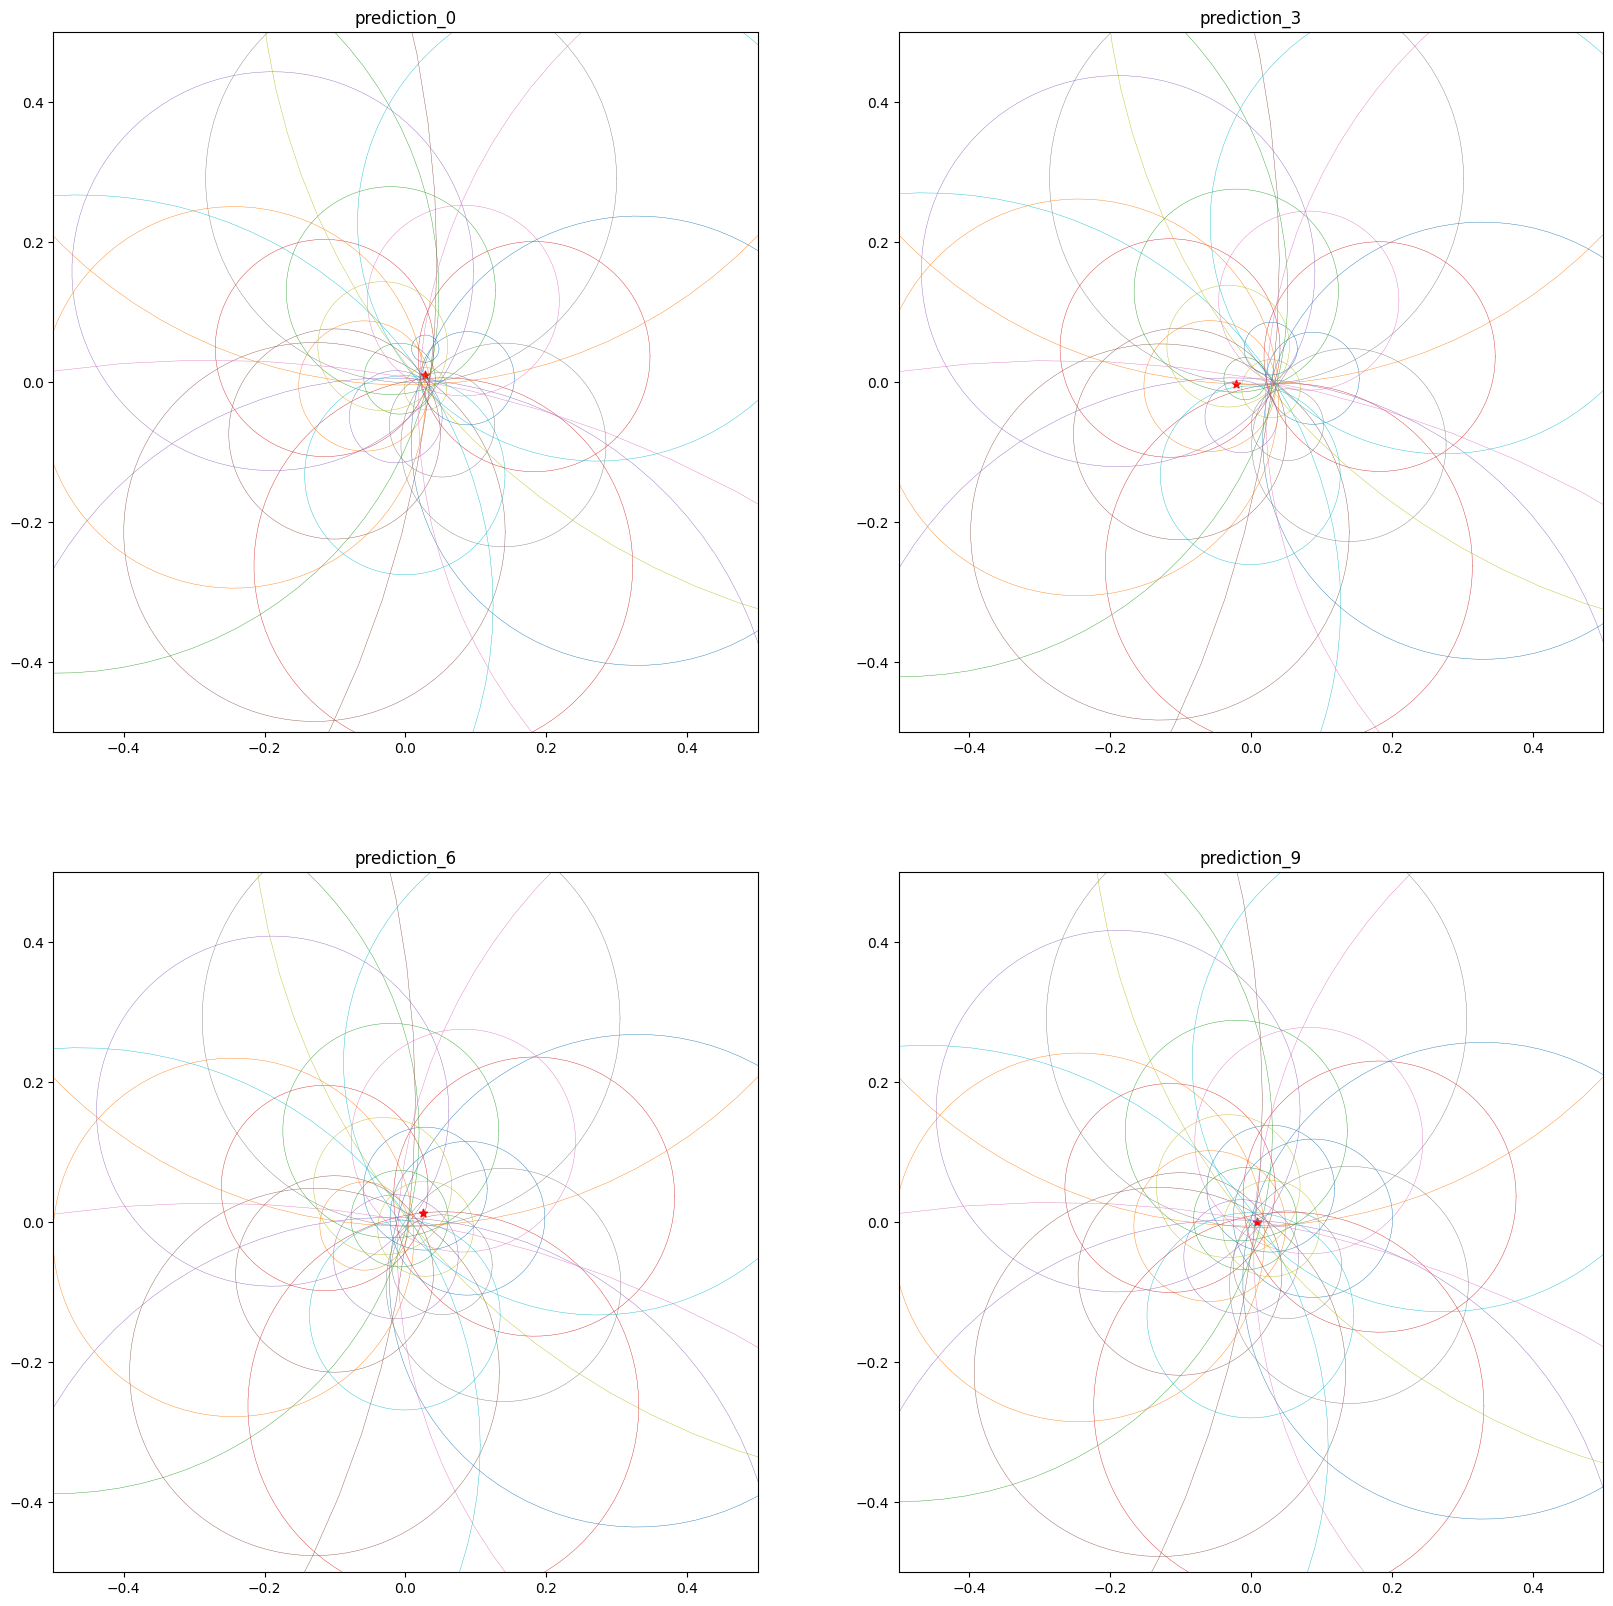

In [269]:
import matplotlib.pyplot as plt
import math

theta = np.linspace(0, 2*np.pi, 100)

first_index = ds.get_actual_index(initial_index + batch_index)
pre_indices = [0, 3, 6, 9]
fig, axis = plt.subplots(2, 2, figsize=(20, 20))

# diff_df is dataset to caliculate cluster distances
diff_df = df[columns].diff().dropna()
for i, pre_index in enumerate(pre_indices):
    row_data = diff_df.iloc[first_index + observation_length + pre_index]
    row = i // 2
    column = i % 2
    
    axis[row, column].scatter(row_data["open"], row_data["close"], color="red", marker="*")
    axis[row, column].set_title(f"prediction_{pre_index}")
    axis[row, column].set_xlim(-0.5, 0.5)
    axis[row, column].set_ylim(-0.5, 0.5)
    for index in range(30):
        d = math.sqrt(pred_distances[pre_index, index])
        x_circle = ds.centers[index, 0] + d * np.cos(theta)
        y_circle = ds.centers[index, 1] + d * np.sin(theta)
        axis[row, column].plot(x_circle, y_circle, linewidth=0.3)


plt.show()

In [270]:
# sample 2. Looks like if diff value is big, prediction is not good. I assume data is less to train such cases.
batch_index = 3
pred_distances = preds_tgt[1:, batch_index, :]
pred_distances = pred_distances.cpu().detach().numpy()
pred_distances = np.abs(pred_distances)

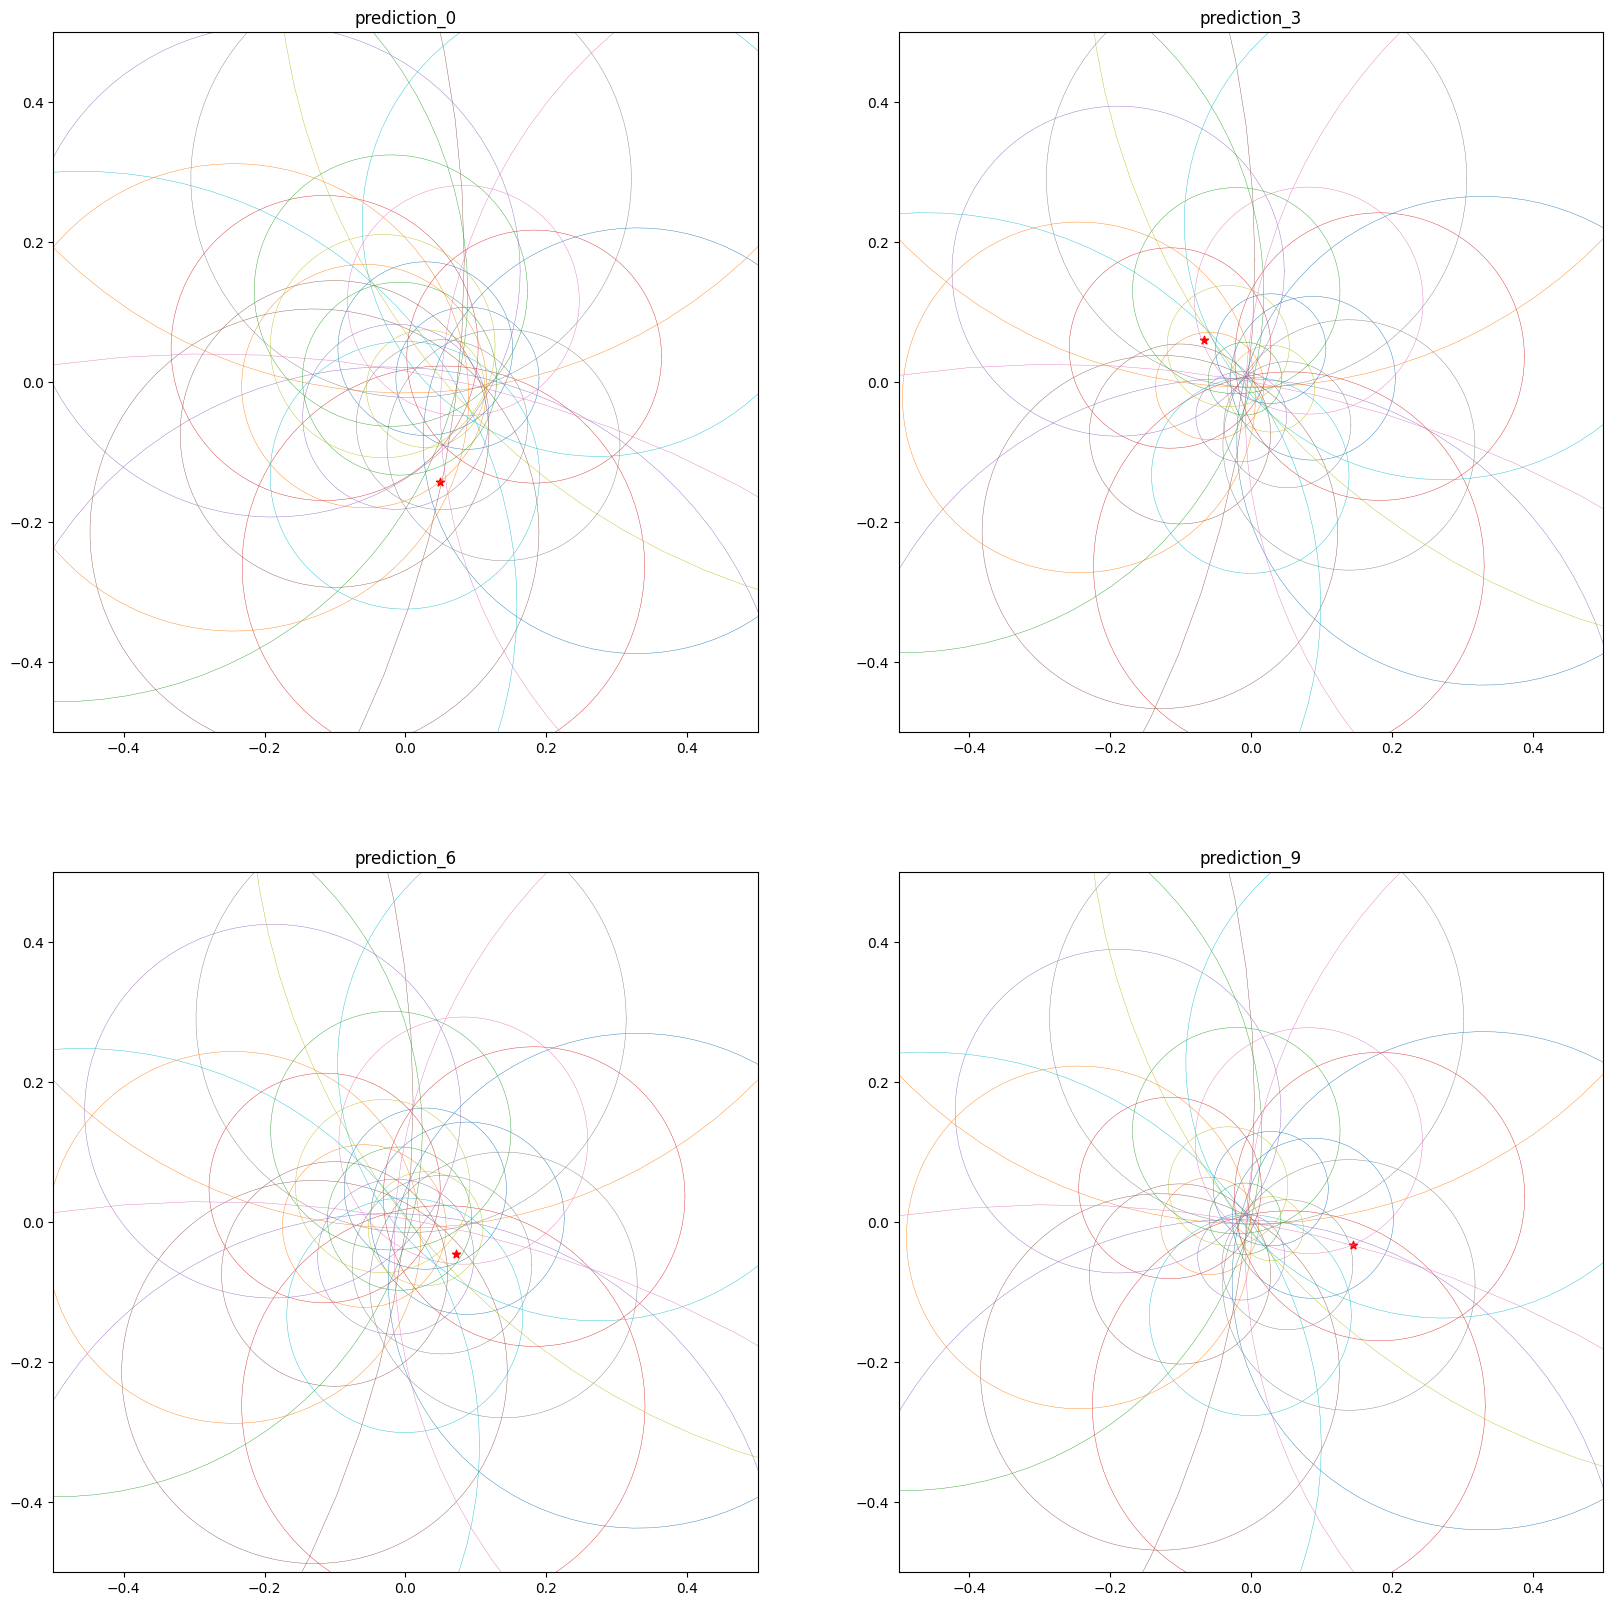

In [271]:
theta = np.linspace(0, 2*np.pi, 100)

first_index = ds.get_actual_index(initial_index + batch_index)
pre_indices = [0, 3, 6, 9]
fig, axis = plt.subplots(2, 2, figsize=(20, 20))

diff_df = df[columns].diff().dropna()
for i, pre_index in enumerate(pre_indices):
    row_data = diff_df.iloc[first_index + observation_length + pre_index]
    row = i // 2
    column = i % 2
    
    axis[row, column].scatter(row_data["open"], row_data["close"], color="red", marker="*")
    axis[row, column].set_title(f"prediction_{pre_index}")
    axis[row, column].set_xlim(-0.5, 0.5)
    axis[row, column].set_ylim(-0.5, 0.5)
    for index in range(30):
        d = math.sqrt(pred_distances[pre_index, index])
        x_circle = ds.centers[index, 0] + d * np.cos(theta)
        y_circle = ds.centers[index, 1] + d * np.sin(theta)
        axis[row, column].plot(x_circle, y_circle, linewidth=0.3)


plt.show()

In [ ]:
# Idea 1: sum overlapped areas

In [316]:
center = centers.values[0:1]
_distances = np.sqrt(distances)

In [591]:
unit = 0.001

x_max = (diff_df["open"].max() // unit) * unit
x_min = (diff_df["open"].min() // unit) * unit
y_max = (diff_df["close"].max() // unit) * unit
y_min = (diff_df["close"].min() // unit) * unit
print(x_min, x_max)
print(y_min, y_max)

-2.399 1.502
-2.398 1.5010000000000001


In [592]:
x_coords = np.arange(x_min, x_max, unit)
y_coords = np.arange(y_min, y_max, unit)

#### Test the idea with sample data

In [549]:
debug_coords = []
for x in x_coords:
    debug_y_coords = []
    for y in y_coords:
        debug_y_coords.append((x, y))
    debug_coords.append(debug_y_coords)
debug_coords = np.asarray(debug_coords)

In [547]:
debug_coords[0, 0], debug_coords.shape

(array([-2.398, -2.399]), (3901, 3899, 2))

In [374]:
density = np.zeros([len(x_coords), len(y_coords)])
density.shape

(3901, 3899)

In [569]:
center = np.asarray((0.002, -0.001))
distance = 0.02345

x = x_coords[((center[0] - distance) <= x_coords) & (x_coords <= (center[0] + distance))]
y = y_coords[((center[1] - distance) <= y_coords) & (y_coords <= (center[1] + distance))]

In [469]:
math.sqrt((x.max() - center[0]) ** 2 + (y.max() - center[1]) ** 2)

0.03252691193420384

In [481]:
X, Y = np.meshgrid(x, y)
dist = np.sqrt(((X - center[0])**2 + (Y - center[1])**2))

In [482]:
dist.max()

0.032526911934951365

In [492]:
dist.min()

3.7375996951852435e-13

In [507]:
test = (distance - dist) / (math.sqrt(2)*unit)

In [508]:
test.max(), test.min()

(16.581654018560247, -6.418345981437216)

In [509]:
test_clipped = np.clip(test, 0, 1)

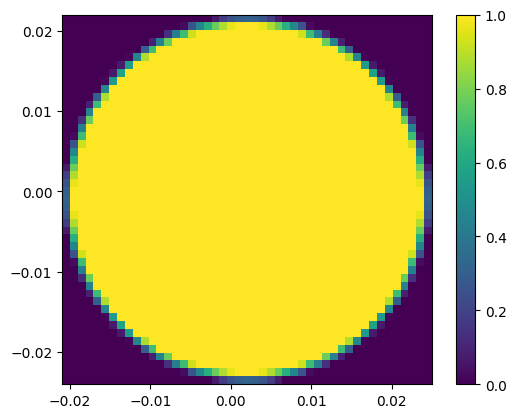

In [510]:
plt.imshow(test_clipped, origin='lower', extent=(min(x), max(x), min(y), max(y)))
plt.colorbar()
plt.show()

In [669]:
x_index = int(x[0] / unit)
y_index = int(y[0] / unit)
x_min_index = int((-x_min + x[0])/unit)
y_min_index = int((-y_min + y[0])/unit)

In [671]:
units = round((distance * 2) / unit) 
x_max_index = x_min_index + units
y_max_index = y_min_index + units

In [672]:
(x_min_index, x_max_index), (y_min_index, y_max_index)

((2377, 2424), (2373, 2420))

In [673]:
print(debug_coords[x_min_index, y_min_index])
print("to")
print(debug_coords[x_max_index, y_max_index])

[-0.022 -0.025]
to
[0.025 0.022]


In [622]:
print(center, distance)

[ 0.002 -0.001] 0.02345


In [674]:
test_clipped.shape

(47, 47)

In [675]:
density[x_min_index:x_max_index, y_min_index:y_max_index] += test_clipped

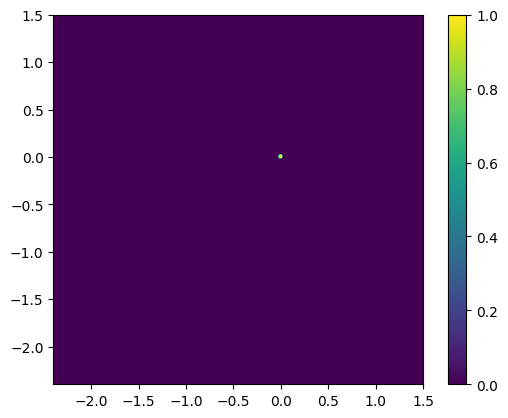

In [678]:
plt.imshow(density, origin='lower', extent=(x_min, x_max, y_min, y_max))
plt.colorbar()
plt.show()

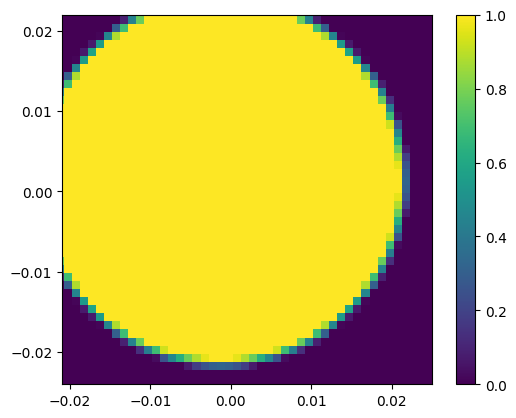

In [679]:
plt.imshow(density, origin='lower', extent=(x_min, x_max, y_min, y_max))
plt.colorbar()
plt.xlim(x.min(), x.max())
plt.ylim(y.min(), y.max())
plt.show()

#### Try the idea with actual data

In [720]:
x_indices = np.arange(0, len(x_coords))
y_indices = np.arange(0, len(y_coords))

In [768]:
density = np.zeros([len(x_coords), len(y_coords)])
density_shape = density.shape
prediction_index = 9

UNIT_DIST = math.sqrt(2)*unit

for center_index in range(cluster_size):
    distance = math.sqrt(pred_distances[prediction_index, center_index])
    center = ds.centers[center_index]
    x_cond = ((center[0] - distance) <= x_coords) & (x_coords <= (center[0] + distance))
    y_cond = ((center[1] - distance) <= y_coords) & (y_coords <= (center[1] + distance))
    x = x_coords[x_cond]
    y = y_coords[y_cond]
    
    X, Y = np.meshgrid(x, y)
    d = np.sqrt(((X - center[0])**2 + (Y - center[1])**2))
    
    # note that this and later density doesn't mean probability density
    cluster_density = (distance - d) / UNIT_DIST
    cluster_density = np.clip(cluster_density, 0, 1)
    
    x_length, y_length = d.shape
    
    cluster_x_indices = x_indices[x_cond]
    x_min_index = cluster_x_indices[0]
    x_max_index = x_min_index + x_length
    
    cluster_y_indices = y_indices[y_cond]
    y_min_index = cluster_y_indices[0]
    y_max_index = y_min_index + y_length
    
    if x_max_index <= density_shape[0]:
        if y_max_index <= density_shape[1]:
            density[x_min_index:x_max_index, y_min_index:y_max_index] += cluster_density
        else:
            over_y_index = y_max_index - density_shape[1]
            density[x_min_index:x_max_index, y_min_index:y_max_index] += cluster_density[:, :-over_y_index]
    else:
        over_x_index = x_max_index - density_shape[0]
        if y_max_index <= density_shape[1]:
            
            density[x_min_index:x_max_index, y_min_index:y_max_index] += cluster_density[:-over_x_index, :]
        else:
            over_y_index = y_max_index - density_shape[1]
            density[x_min_index:x_max_index, y_min_index:y_max_index] += cluster_density[:-over_x_index, :-over_y_index]

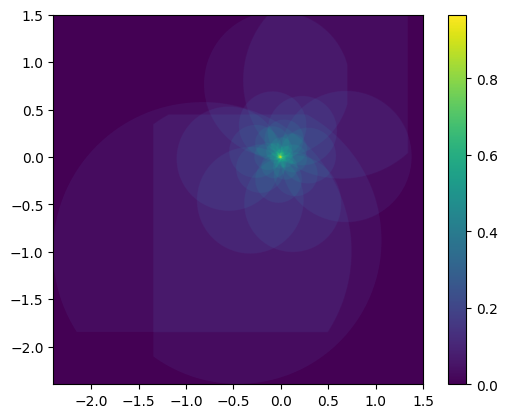

In [769]:
plt.imshow(density/30, origin='lower', extent=(x_min, x_max, y_min, y_max))
plt.colorbar()
plt.show()

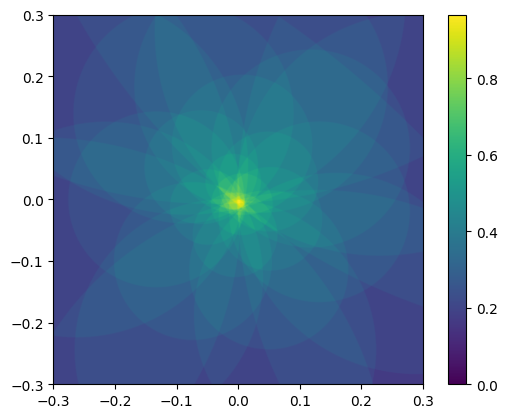

In [770]:
plt.imshow(density/30, origin='lower', extent=(x_min, x_max, y_min, y_max))
plt.colorbar()
plt.xlim(-0.3, 0.3)
plt.ylim(-0.3, 0.3)
plt.show()